In [1]:
#packages we need
using DifferentialEquations
using Plots 
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using DelimitedFiles
using OrdinaryDiffEq
using LinearAlgebra
using FiniteDiff
using FileIO

In [2]:
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
      denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

      #GM growth (biosynthesis of ribosomes and all necessary machinery)
      #previous iterations had numerator/denominator<0.8
      #diffEq.jl requires a function that hits 0
      (numerator/denominator)-0.8
end

function affect!(integrator)
  print("r31 event to 0\n")
  #update r31Switch to 0
  integrator.u[indexOfSwitch] = 0
end

function affectNeg!(integrator)
  print("r31 event to 1\n")
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0

      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end

## all equal function
function allequal(obj)
    local x
    isfirst = true
    for i in obj
        if isfirst
            x = i
            isfirst = false
        else
            isequal(x, i) || return false
        end
    end
    return true
end

function affectCdh!(integrator)

  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass

   integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
#   #Gm to 0.5 * Gm
   integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
# end
# end
  if integrator.u[indexOfMass]<0.5
    #print("new switch 0 during division\n")
    integrator.u[indexNewSwitch]=0
  else
    #print("new switch 1 during division\n")
    integrator.u[indexNewSwitch]=1
  end
 
    #store the latest peak mass in the last spot and shuffle every entry down one.
    integrator.u[indexOfMassTracker5]=integrator.u[indexOfMassTracker4]
    integrator.u[indexOfMassTracker4]=integrator.u[indexOfMassTracker3]
    integrator.u[indexOfMassTracker3]=integrator.u[indexOfMassTracker2]
    integrator.u[indexOfMassTracker2]=integrator.u[indexOfMassTracker1]
    integrator.u[indexOfMassTracker1]=round(integrator.u[indexOfMass], digits=3)
    integrator.u[indexOfMassTrackerTime5]=integrator.u[indexOfMassTrackerTime4]
    integrator.u[indexOfMassTrackerTime4]=integrator.u[indexOfMassTrackerTime3]
    integrator.u[indexOfMassTrackerTime3]=integrator.u[indexOfMassTrackerTime2]
    integrator.u[indexOfMassTrackerTime2]=integrator.u[indexOfMassTrackerTime1]
    integrator.u[indexOfMassTrackerTime1]=integrator.t
    lastPeaks=[integrator.u[indexOfMassTracker5] integrator.u[indexOfMassTracker4] integrator.u[indexOfMassTracker3] integrator.u[indexOfMassTracker2] integrator.u[indexOfMassTracker1]]
    if allequal(lastPeaks)
        
       terminate!(integrator)
    end

 #print("division event\n")
end

## extra functions to stop the cell cycling when mass drops below 0.5

function conditionMass(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #triggers when mass crosses 0.5
      cellcycle[indexOfMass]-0.5
end

function affectMass!(integrator)
    integrator.u[indexNewSwitch] = 1
    #print("new switch 1\n")
end

function affectMassNeg!(integrator)
    integrator.u[indexNewSwitch] = 0
    #print("new switch 0\n")
end

affectMassNeg! (generic function with 1 method)

In [3]:
#use the callbacks described above to trigger events
cb = ContinuousCallback(condition,affect!,affectNeg!)
cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing)
cb3 = ContinuousCallback(conditionMass,affectMass!,affectMassNeg!)
cbs=CallbackSet(cb,cb2,cb3)

CallbackSet{Tuple{ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionCdh), typeof(affectCdh!), Nothing, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionMass), typeof(affectMass!), typeof(affectMassNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{}}((ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affectNeg!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1

In [4]:
function initConditionsCellCycle(y0,syms,myc)
   #units: M 
   y0[findfirst(isequal("ERG"),syms)]=0.0121809 
   y0[findfirst(isequal("p27_cycA_Cdk2"),syms)]=0.0356927
   y0[findfirst(isequal("p27"),syms)]=0.00922806
   y0[findfirst(isequal("Cdc20"),syms)]=0.00220177 
   y0[findfirst(isequal("p27_cycE_Cdk2"),syms)]=0.000542587
   y0[findfirst(isequal("cycE"),syms)]=0.0229112 
   y0[findfirst(isequal("cycA"),syms)]=1.4094 
   y0[findfirst(isequal("cycB"),syms)]=2.72898
   y0[findfirst(isequal("p27_cycD_Cdk2"),syms)]=0.010976 
   y0[findfirst(isequal("cycD"),syms)]=0.43929 
   y0[findfirst(isequal("Cdh1"),syms)]=0.000653278 
   y0[findfirst(isequal("DRG"),syms)]=0.900533
   y0[findfirst(isequal("PPX"),syms)]=1.0
   y0[findfirst(isequal("IEP"),syms)]=0.154655
   y0[findfirst(isequal("Cdc20t"),syms)]=2.36733
   y0[findfirst(isequal("E2F_Rb"),syms)]=0.00478911
   y0[findfirst(isequal("E2F"),syms)]=0.989986
   y0[findfirst(isequal("HypoP_Rb"),syms)]=9.97574
   y0[findfirst(isequal("pE2F_Rb"),syms)]=0.0192822
   y0[findfirst(isequal("pE2F"),syms)]=3.98594
   y0[findfirst(isequal("GM"),syms)]=1.35565
   y0[findfirst(isequal("r31switch"),syms)]=1
   y0[findfirst(isequal("cMyc"),syms)]=myc
   y0[findfirst(isequal("Mass"),syms)]=1
   y0[findfirst(isequal("newSwitch"),syms)]=1
   y0[findfirst(isequal("Rb"),syms)]=0
   y0[findfirst(isequal("cMyct"),syms)]=40
   return y0
end

initConditionsCellCycle (generic function with 1 method)

In [5]:
### NEW FUNCTION

function Get_CC_transitions(sol_SS, time_stamp_SS)
  Cdh1_col = columnindex(sol_SS, :Cdh1)
  cycA_col = columnindex(sol_SS, :cycA)
  cycB_col = columnindex(sol_SS, :cycB)
  cycE_col = columnindex(sol_SS, :cycE)
  Mass_col = columnindex(sol_SS, :Mass)

  sol_SS_cc = sol_SS[:, [Cdh1_col,cycA_col,cycB_col,cycE_col,Mass_col]]

  # G1 -> S boundary when cycB is > 0 (or close to 0)cycB_peak_df = convert_colname(max_cycB[2])
  # S to G2 when CycE is gone but before peak in CycA
  # G2 to M at peak of CycB before rapid decrease in CycB, CycA should already be decreasing and about half way gone.

  SS_zero = convert(Int64, round(time_stamp_SS[1], digits=0))

  ##G1/S
  max_Cdh1 = findmax(sol_SS_cc[:,1])
  submax_Cdh1 = (max_Cdh1[1]/100)*95
  submax_Cdh1 = findfirst(x->x>submax_Cdh1, sol_SS_cc[:,1])
  G1S_df = sol_SS_cc[submax_Cdh1:nrow(sol_SS_cc),:]
  col_Cdh1 = G1S_df[:,1]  
  half_max_Cdh1 = max_Cdh1[1]*0.5
  G1S=findfirst(x->x<half_max_Cdh1,col_Cdh1)
  G1S_t = convert(Int64, round(time_stamp_SS[G1S+submax_Cdh1],digits=0))
  G1S_t = G1S_t - SS_zero
    
  ## S/G2
  G1St = SS_zero+G1S_t
  G1St_TS = findfirst(x->x>G1St, time_stamp_SS)
  # get max value of cycA
  colcycA = sol_SS_cc[:,2]
  max_cycA = findmax(colcycA[G1St_TS:end])
  # get time when cycA is max - 2.5%
  submaxA = (max_cycA[1]/100)*97.5
  submaxA = findfirst(x->x>submaxA,colcycA)
  SG2_t = convert(Int64, round(time_stamp_SS[submaxA],digits=0))
  SG2_t = SG2_t - SS_zero

  ## G2/M
  SG2t = SS_zero+SG2_t
  SG2t_TS = findfirst(x->x>SG2t, time_stamp_SS)
  col_cycB = sol_SS_cc[:,3]
  max_cycB = findmax(col_cycB[SG2t_TS:end])
  #submaxB = (max_cycB[1]/100)*97.5
  max_cycB = findfirst(x->x==max_cycB[1],col_cycB)
  G2M_time = convert(Int64, round(time_stamp_SS[max_cycB],digits=0))
  G2M_t = G2M_time - SS_zero

  ## M
  M_t = convert(Int64, round(time_stamp_SS[end],digits=0)) - SS_zero

  return(G1S_t,SG2_t,G2M_t,M_t)

end

Get_CC_transitions (generic function with 1 method)

### Set solve conditions

In [6]:
maxTimeSS=100000.0
maxTimeTC=24*60.0

DISincrease=0.000001

## set time to solve
TCLength=300*60
## set max attempts to find steady state
maximumAttemptsAtSS=20

20

In [7]:
global colnames=["G1S", "SG2", "G2M", "M"];

In [8]:
### Files
rateLawsFile="moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv"
reactionsFile="moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv"
parametersFile="moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv"

"moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv"

In [9]:
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeCellCycle.jl", "scan"]
locationOfCSV2Julia="CSV2JuliaDiffEq/csv2model-multiscale.py"
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv as rate law file
Opening moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv as parameters file
Opening moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv as reactions file


Process(`python3 CSV2JuliaDiffEq/csv2model-multiscale.py moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv odeCellCycle.jl scan`, ProcessExited(0))

In [10]:
mv("odeCellCycle.jl","modelFiles/cellCycle/odeCellCycle.jl", force=true)
mv("variableNames.jl","modelFiles/cellCycle/variableNamesCellCycle.jl", force=true)

"modelFiles/cellCycle/variableNamesCellCycle.jl"

In [11]:
include("modelFiles/cellCycle/odeCellCycle.jl")
include("modelFiles/cellCycle/variableNamesCellCycle.jl")
include("scanIncludes.jl")

parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5


In [12]:
include("utilityFunctions/fixSpecies.jl")
locationOfodefile = "modelFiles/cellCycle/odeCellCycle.jl"
locationOfodefixed = "modelFiles/cellCycle/odeCellCycleFixed_myc.jl"
fixSpecies(locationOfodefile,locationOfodefixed, 23)

In [12]:
locationOfVariableNames="modelFiles/cellCycle/variableNamesCellCycle.jl"
include(locationOfVariableNames)
indexOfMass=findfirst(x->"Mass"==x,syms)
indexOfGM=findfirst(x->"GM"==x,syms)
indexNewSwitch=findfirst(x->"newSwitch"==x,syms)
indexOfRb=findfirst(x->"Rb"==x,syms)
indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms)
indexOfSwitch=findfirst(x->"r31switch"==x,syms)
indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
indexOfMassTracker1=findfirst(x->"previousMass1"==x,syms)
indexOfMassTracker2=findfirst(x->"previousMass2"==x,syms)
indexOfMassTracker3=findfirst(x->"previousMass3"==x,syms)
indexOfMassTracker4=findfirst(x->"previousMass4"==x,syms)
indexOfMassTracker5=findfirst(x->"previousMass5"==x,syms)
indexOfMassTrackerTime1=findfirst(x->"previousMassTime1"==x,syms)
indexOfMassTrackerTime2=findfirst(x->"previousMassTime2"==x,syms)
indexOfMassTrackerTime3=findfirst(x->"previousMassTime3"==x,syms)
indexOfMassTrackerTime4=findfirst(x->"previousMassTime4"==x,syms)
indexOfMassTrackerTime5=findfirst(x->"previousMassTime5"==x,syms)

37

In [13]:
syms=Symbol.(syms)

37-element Vector{Symbol}:
 :ERG
 :p27_cycA_Cdk2
 :p27
 :Cdc20
 :p27_cycE_Cdk2
 :cycE
 :cycA
 :cycB
 :p27_cycD_Cdk2
 :cycD
 :Cdh1
 :DRG
 :PPX
 ⋮
 :Rb
 :cMyct
 :previousMass1
 :previousMass2
 :previousMass3
 :previousMass4
 :previousMass5
 :previousMassTime1
 :previousMassTime2
 :previousMassTime3
 :previousMassTime4
 :previousMassTime5

In [15]:
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/")
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/WT/")
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/Myc_x1point5/")
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/WTpx5/")
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/Myc_x5/")
mkpath("outputFiles/cellCycle/Param_scan/PS_150622/Myc_x5_px5/")

"outputFiles/cellCycle/Param_scan/PS_150622/Myc_x5_px5"

In [16]:
#### run multiple mutation simulation

function param_scan(mod, date, mut)

    for (key, value) in modify
        include("utilityFunctions/fixSpecies.jl")
        run(cmd)
        include(locationOfodefile)
        fixSpecies(locationOfodefile,locationOfodefixed, 23)
        odeCellCycle = include(locationOfodefixed)
        include(locationOfVariableNames)
        include("scanIncludes.jl")
        
        f=ODEFunction(odeCellCycle,syms=syms)
        y0=zeros(length(syms))
        y0=initConditionsCellCycle(y0,String.(syms), 80)
        prob=ODEProblem(f,y0,(0.0,maxTimeSS))

        println("Solving for " ,key, "...")
    
        modify[key] = mod

        ### solve
        sol = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)
            sol_df = DataFrame(sol', syms)
        if(sol.t[end]==maxTimeSS)
            println("Cell: "*string(key)*" ended without finding a steady state in time.")
        else
            println("Cell: "*string(key)*" reached a steady state.")
        
            ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
            time_stamp = sol.t
            sol_df[!, :time_stamp] = time_stamp
            #CSV.write("outputFiles_cell_cycle/"*mut_folder*"/solutions/sol_df_"*string(i)*".csv", sol_df)
            indexOfLastCycleStart=findfirst(x->x>sol[indexOfMassTrackerTime2,end],sol.t)
            sol_SS = sol_df[indexOfLastCycleStart:end, :]

            # get time stamp
            time_stamp_SS = sol_SS[:, :time_stamp]

            ### Calculate times for cell cycle transitions
            plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
            println("plot times calculated for cell "*string(key))
            CSV.write("outputFiles/cellCycle/Param_scan/PS_"*date*"/"*mut*"/plot_times_"*key*".csv", plot_times)         
        end
        flush(stdout)
    end
end

param_scan (generic function with 1 method)

In [17]:
param_scan(5, "150622", "Myc_x5_px5")

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv as rate law file
Opening moduleDefinitionFiles/cellCycle/parameters_plus_myc_mutx5.csv as parameters file
Opening moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5
Solving for k1_34...
Cell: k1_34 reached a steady state.
plot times calculated for cell k1_34
scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Open

In [18]:
function GetTimesPS(date, folder)
    ## create empty DataFrame for results
    plot_times_df = DataFrame(G1S=Int64[], SG2=Int64[], G2M=Int64[], M=Int64[], param=String[])
    
    for (key, value) in modify

        if isfile("outputFiles/cellCycle/Param_scan/PS_"*date*"/"*folder*"/plot_times_"*key*".csv") == true

    plot_times = DataFrame(CSV.File("outputFiles/cellCycle/Param_scan/PS_"*date*"/"*folder*"/plot_times_"*key*".csv", header=true))

    plot_times[!, :param] = [key]

    append!(plot_times_df, plot_times)

        else 
            continue
        end
    end
    plot_times_df = plot_times_df[(plot_times_df.param .!= "k1_27"), :]
    return plot_times_df
end

GetTimesPS (generic function with 1 method)

## Import and merge times

In [32]:
PS_times_WT = GetTimesPS("150622", "WT")
PS_times_WT_M = PS_times_WT[!, [4,5]]
rename!(PS_times_WT_M, :M => :WT)
PS_times_Myc_mut = GetTimesPS("150622", "Myc_x1point5")
PS_times_Myc_mut_M = PS_times_Myc_mut[!, [4,5]]
rename!(PS_times_Myc_mut_M, :M => :Myc_mut)
PS_times_WT_Myc_comp = innerjoin(PS_times_WT_M, PS_times_Myc_mut_M, on = :param)
PS_times_WT_Myc_comp[!, :diff] = PS_times_WT_Myc_comp[!, :WT] - PS_times_WT_Myc_comp[!, :Myc_mut]

73-element Vector{Int64}:
 14
  9
  9
  9
  9
 10
  8
 12
  9
  9
  9
  9
 25
  ⋮
 10
 11
  9
  9
  8
  8
  9
  8
  4
  4
  9
  8

In [33]:
sort!(PS_times_WT_Myc_comp, [:diff], rev=true)

,WT,param,Myc_mut,diff
,Int64,String,Int64,Int64
1,2646,k1_18,2597,49
2,1633,k1_10,1606,27
3,1530,k3_pp1t,1505,25
4,1530,k1_19,1505,25
5,634,k2_17,617,17
6,638,k1_6a,621,17
7,643,k1_20,627,16
8,636,k2_9,620,16
9,642,k1_31,627,15


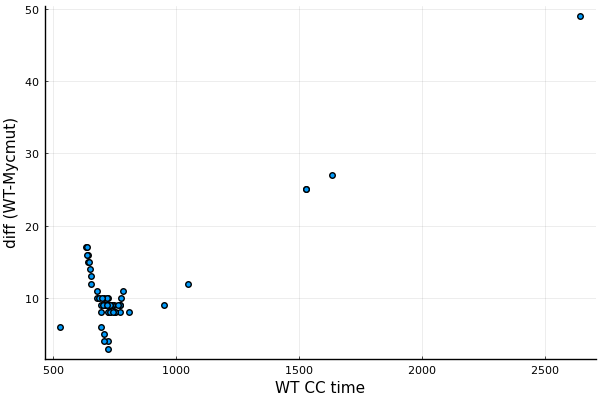

In [39]:
scatter(PS_times_WT_Myc_comp[!, :WT], PS_times_WT_Myc_comp[!, :diff], 
    xlab="WT CC time", ylab="diff (WT-Mycmut)", legend=false)

In [172]:
PS_times_Myc_mut = GetTimesPS("150622", "Myc_x1point5")

,G1S,SG2,G2M,M,param
,Int64,Int64,Int64,Int64,String
1,313,525,610,637,k1_34
2,295,579,679,721,k3_j15
3,294,578,679,721,k3_newSwitch
4,293,577,677,719,k1_24
5,296,595,698,739,k4_j1
6,268,553,654,695,k1_26r
7,303,586,688,730,k1_mycDeg
8,291,576,676,718,k3_ha
9,215,507,600,642,k1_22


### make copy, modify results, convert to matrix

In [19]:
# get length of each part of the cell cycle from the end times
function res_mod(df)
      for i in 1:nrow(df)
            df[i,4]=df[i,4] - df[i,3]
            df[i,3]=df[i,3] - df[i,2]
            df[i,2]=df[i,2] - df[i,1]
      end
      return(df)
end

res_mod (generic function with 1 method)

In [20]:
function paramsMod(plot_times_df)
    params=deepcopy(plot_times_df[!, :param])
    replace!(params, "k1_16" => "ERG_deg", "k1_30" => "CycA_deg", "k1_25R" => "p27_cycE_Cdk2_deg", "k2_5" => "p27_exp", "k1_18" => "DRG_deg", "k1_12" => "Cdc20t_deg")
    replace!(params, "k1_13" => "Cdc20_exp1", "k2_j13" => "Cdc20_exp2", "k1_14" => "Cdc20_deg1", "k2_j14" => "Cdc20_deg2")
    replace!(params, "k1_10" => "p27_cycD_Cdk2_deg", "k2_mu" => "mass_gain", "k2_15" => "ERG_exp2", "k3_j15" => "ERG_exp3", "k2_11a" => "Cdc20t_exp2", "k3_11" => "Cdc20t_exp3", "k2_29" => "cycA_exp")
    replace!(params, "k1_3a" => "Cdh1_exp1", "k2_3" => "Cdh1_exp2", "k3_J3" => "Cdh1_exp3", "k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4")
    replace!(params, "k1_23a" => "E2F_phos1", "K2_3a" => "E2F_phos2")
    replace!(params, "k2_17" => "DRG_exp2", "k3_j17" => "DRG_exp3", "k4_17a" => "DRG_exp4", "k1_j4" => "Cdh1_deg1", "k2_4" => "Cdh1_deg2", "k3_ga" => "Cdh1_deg3", "k4_gb" => "Cdh1_deg4", "k5_ge" => "Cdh1_deg5")
    replace!(params, "k2_1a" => "cycB_exp2", "k3_1" => "cycB_exp3", "k4_j1" => "cycB_exp4", "k2_7a" => "cycE_exp2", "k3_7" => "cycE_exp3", "k1_31" => "IEP_exp1", "k2_j31" => "IEP_exp2")
    replace!(params, "k1_8a" => "p27.cycE.Cdk2_degp27_1", "k2_8" => "p27.cycE.Cdk2_degp27_2", "k3_yb" => "p27.cycE.Cdk2_degp27_3", "k4_ye" => "p27.cycE.Cdk2_degp27_4", "k5_j8" => "p27.cycE.Cdk2_degp27_5")
    replace!(params, "k1_22" => "pE2F_Rb_dephos", "k1_34" => "PPX_deg")
    replace!(params, "k1_25" => "cycAp27_bind_Cdk2", "k1_26" => "E2F_bind_Rb", "k2_23" => "E2F_phos2", "k3_2" => "cycB_deg3", "k2_2a" => "cycB_deg2", "k1_J4" => "Cdh1_deg")
    replace!(params, "k1_24r" => "p27_cycD_Cdk2_deg")
    replace!(params, "k2_9" => "cycD_exp", "k2_19a" => "Rb_phos2", "k4_21" => "Rb_phos4", "k5_fb" => "Rb_phos5", "k6_fe" => "Rb_phos6")
    replace!(params, "k1_6a" => "p27.cycE/D/A.Cdk2_deg1", "k2_6" => "p27.cycE/D/A.Cdk2_deg2", "k3_ha" => "p27.cycE/D/A.Cdk2_deg3", "k4_hb" => "p27.cycE/D/A.Cdk2_deg4", "k5_he" => "p27.cycE/D/A.Cdk2_deg5")
    replace!(params, "k1_20" => "E2F_Rb_diss1", "k2_la" => "E2F_Rb_diss2", "k3_lb" => "E2F_Rb_diss3", "k4_ld" => "E2F_Rb_diss4", "k5_le" => "E2F_Rb_diss5")
    replace!(params, "k1_24" => "p27.cycD_binds_Cdk2", "k1_2aa" => "cycB_exp1b", "k2_j32" => "IEP_deg2", "k1_26r" => "pE2F_Rb_prod")
    replace!(params, "k1_28" => "GM_prod", "k1_19" => "Rb_phos1", "k3_pp1t" => "Rb_phos3")
    plot_times_df[!, :param] = params
    return(plot_times_df)
end

paramsMod (generic function with 1 method)

## Plotting

In [21]:
using StatsPlots

In [22]:
pyplot()

Plots.PyPlotBackend()

In [23]:
function PStimesMod(plot_times_df)
    PS_times_mod = paramsMod(plot_times_df)
    sort!(PS_times_mod, [:M], rev=true)
    return(PS_times_mod)
end

PStimesMod (generic function with 1 method)

In [24]:
function resModPlot(plot_times_df, mod)
    
    CC_res = deepcopy(plot_times_df[!, 1:4])
    
    CC_res_mod = Matrix(res_mod(CC_res))

    G1 = CC_res[:,1]
    S = CC_res[:,2]
    G2 = CC_res[:,3]
    M = CC_res[:,4]

    # get plot names
    plot_names=plot_times_df[!, :param]

    plot = StatsPlots.groupedbar([M G2 S G1],
            bar_position = :stack,
            bar_width = 1,
            label=["M" "G2" "S" "G1"],
            xlim=(0,60*55),
            yticks=(1:length(plot_names),plot_names),
            ytickfont=font(6),
            orientation = :horizontal,
            legend=:right,
            title="mod = x"*string(mod),
            size=(800,1000)
            )
    s=string.(collect(0:5:55))
    plot!(xticks = (0:(60*5):(60*55),s),xlabel="time (hours)",fmt = :png)
    vline!([309], color=:black, linestyle=:dash, lw=1, label="G1/S WT 309 mins")
    vline!([592], color=:black, linestyle=:dash, lw=1.5, label="S/G2 WT 592 mins")
    vline!([688], color=:black, linestyle=:dash, lw=2, label="G2/M WT 688 mins")
    vline!([730], color=:black, linestyle=:dash, lw=2.5, label="M WT 730 mins")
    
    return(plot)
end

resModPlot (generic function with 1 method)

In [25]:
function GetPlotRes(folder, mut, mod)
    PS_times = GetTimesPS(folder, mut)
    PS_times_mod = PStimesMod(PS_times)
    resModPlot(PS_times_mod, mod)
end

GetPlotRes (generic function with 1 method)

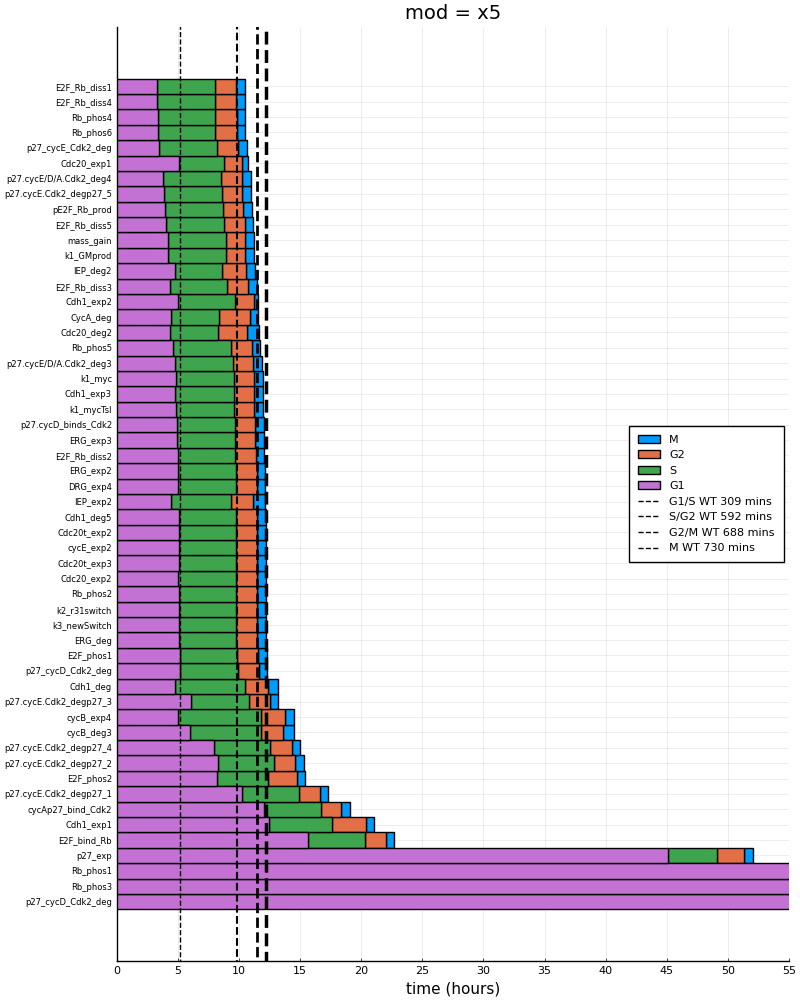

In [64]:
GetPlotRes("150622", "WTpx5", 5)

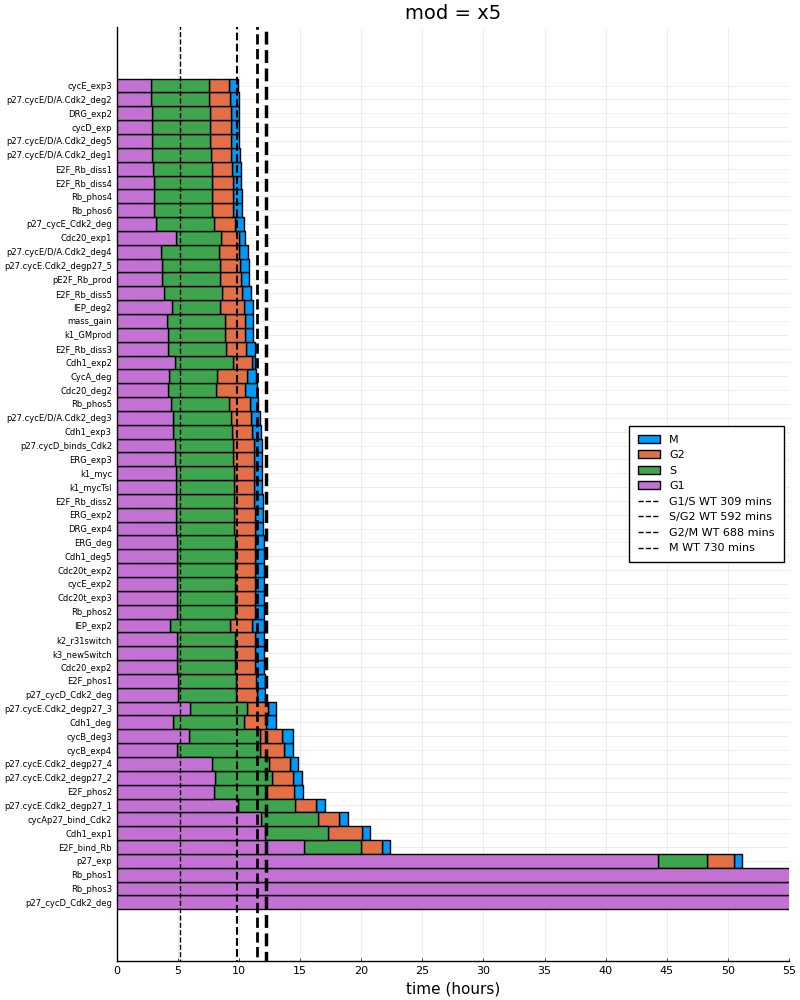

In [26]:
GetPlotRes("150622", "Myc_x5", 5)

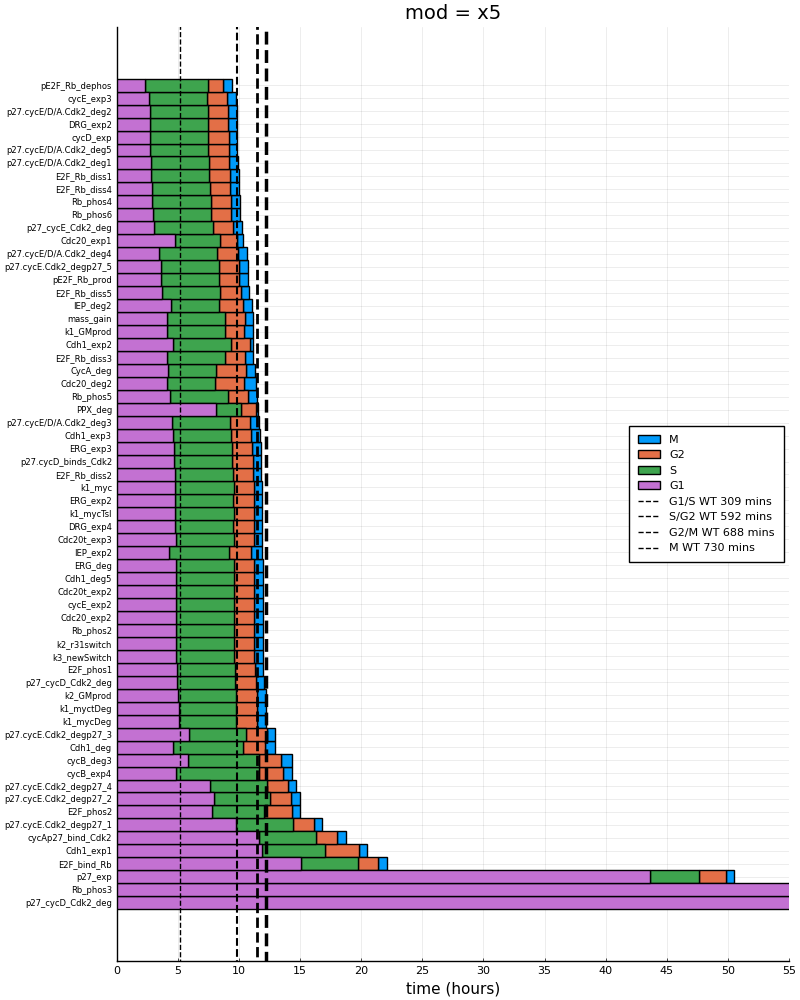

In [27]:
GetPlotRes("150622", "Myc_x5_px5", 5)

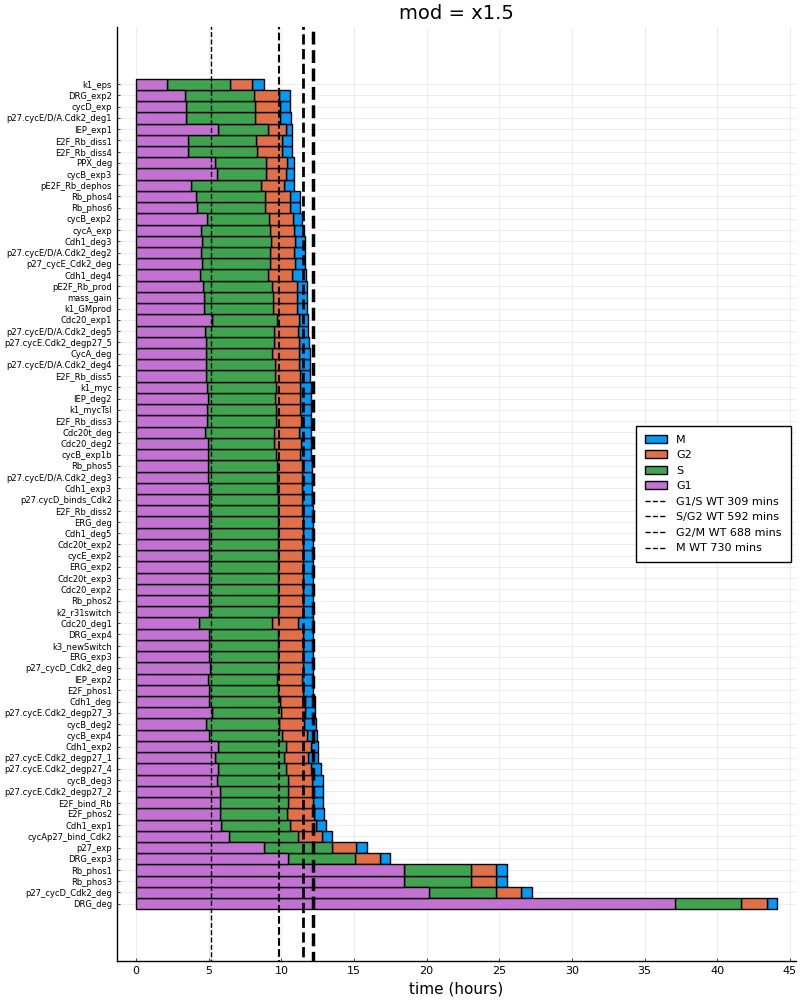

In [163]:
resModPlot(PS_times_WT_mod, 1.5)

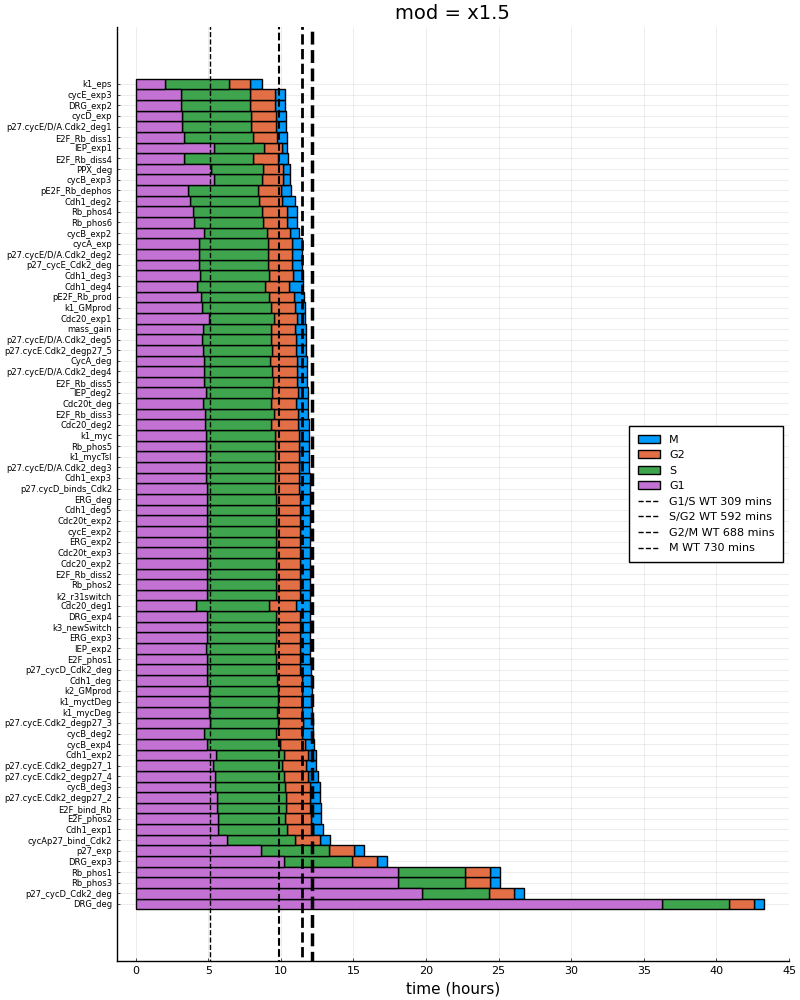

In [175]:
resModPlot(PS_times_Myc_mut_mod, 1.5)

In [102]:
function runSingle(key, mod)
    include("utilityFunctions/fixSpecies.jl")
    run(cmd)
    include("odeCellCycle.jl")
    fixSpecies("odeCellCycle.jl","odeCellCycleFixed_myc.jl", 23)
    odeCellCycle = include("odeCellCycleFixed_myc.jl")
    include("variableNames.jl")
    include("scanIncludes.jl")

    f=ODEFunction(odeCellCycle,syms=syms)
    y0=zeros(length(syms))
    y0=initConditionsCellCycle(y0,String.(syms), 80)
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))

    modify[key] = mod

    ### solve
    sol = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)
    sol_df = DataFrame(sol', syms)
        if(sol.t[end]==maxTimeSS)
            println("Cell: "*string(key)*" ended without finding a steady state in time.")
        else
            println("Cell: "*string(key)*" reached a steady state.")

            ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
            time_stamp = sol.t
            sol_df[!, :time_stamp] = time_stamp
            #CSV.write("outputFiles_cell_cycle/"*mut_folder*"/solutions/sol_df_"*string(i)*".csv", sol_df)
            indexOfLastCycleStart=findfirst(x->x>sol[indexOfMassTrackerTime2,end],sol.t)
            sol_SS = sol_df[indexOfLastCycleStart:end, :]

            # get time stamp
            time_stamp_SS = sol_SS[:, :time_stamp]

            ### Calculate times for cell cycle transitions
            plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
            println("plot times calculated for cell "*string(key))
        end
    return(sol, time_stamp_SS, plot_times)
end

runSingle (generic function with 1 method)

In [103]:
sol_k1_eps = runSingle("k1_eps", 1.5)

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv as rate law file
Opening moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv as parameters file
Opening moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5
Cell: k1_eps reached a steady state.
plot times calculated for cell k1_eps


(OrdinaryDiffEq.ODECompositeSolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, SciMLBase.NullParameters, ODEFunction{true, typeof(odeCellCycle), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{String}, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, CompositeAlgorithm{Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rosenbrock23{10, false, GenericFactorization{LinearSolve.RFWrapper{true, true}}, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rosenbrock23{0, false, Nothing, 

In [104]:
sol_k1_eps[3]

,G1S,SG2,G2M,M
,Int64,Int64,Int64,Int64
1,127,390,479,529


In [1]:
include(locationOfVariableNames)
global indexCdh1=findfirst(x->"Cdh1"==x,syms)
global indexMass=findfirst(x->"Mass"==x,syms)
global indexcycE=findfirst(x->"cycE"==x,syms)
global indexcycA=findfirst(x->"cycA"==x,syms)
global indexcycB=findfirst(x->"cycB"==x,syms)
global indexIEP=findfirst(x->"IEP"==x,syms)
global indexnewSwitch=findfirst(x->"newSwitch"==x,syms)
global indexmyc=findfirst(x->"cMyc"==x,syms)
global indexmyct=findfirst(x->"cMyct"==x,syms)
global indexp27=findfirst(x->"p27_cycE_Cdk2"==x,syms)
global indexcycD=findfirst(x->"cycD"==x,syms)

LoadError: UndefVarError: locationOfVariableNames not defined

In [ ]:
function Plot_CC_PS(mod, key, t)
    ## load solution
    BSON.@load "outputFiles/cellCycle/Param_scan/PS_191121/solutions/sol_"*key*".bson" sol
    
    ## load time stamp
    time_stamp = DataFrame(CSV.File("outputFiles/cellCycle/Param_scan/PS_191121/time_stamps/time_stamp_SS_"*key*".csv", header=false)) 
    rename!(time_stamp, :Column1 => :time)
    
    ## transition times
    plot_times = DataFrame(CSV.File("outputFiles/cellCycle/Param_scan/PS_191121/plot_times/plot_times_"*key*".csv", header=true))
    
    G1_S = trunc(Int, (plot_times[1,1]+time_stamp[1,1]))
    S_G2 = trunc(Int, (plot_times[1,2]+time_stamp[1,1]))
    G2_M = trunc(Int, (plot_times[1,3]+time_stamp[1,1]))
    M = trunc(Int, (plot_times[1,4]+time_stamp[1,1]))
    
    G1S = string(plot_times[1,1])
    SG2 = string(plot_times[1,2])
    G2M = string(plot_times[1,3])
    M_ = string(plot_times[1,4])
    
    Plots.plot(sol, vars=[indexCdh1,indexMass,indexcycE,indexcycA,indexcycB,indexIEP],
      lc=[:green :yellow :purple :red :blue :orange],
      lw=2.5,
      xlims=(time_stamp[1, :time] + t, time_stamp[nrow(time_stamp), :time] + 10),
      #legend=false,
      legend= :outertopright,
      ylims=(0,5),
      title = key*" "*mod,
      fmt = :png)
    
    last_time = trunc(Int, time_stamp[nrow(time_stamp),1]/60)
    s=string.(collect(0:5:last_time))
    plot!(xticks = (0:(60*5):(60*last_time),s),xlabel="time (hours)",fmt = :png)
    
    vline!([G1_S], color=:black, linestyle=:dash, lw=1, label="G1/S "*G1S*" mins")
    vline!([S_G2], color=:black, linestyle=:dash, lw=1.5, label="S/G2 "*SG2*" mins")
    vline!([G2_M], color=:black, linestyle=:dash, lw=2, label="G2/M "*G2M*" mins")
    vline!([M], color=:black, linestyle=:dash, lw=2.5, label="M "*M_*" mins")
end

In [ ]:
sort!(plot_times_df, [:M])

In [ ]:
show(plot_times_df, allrows=true)

In [ ]:
params_run = plot_times_df[!, :param]

In [ ]:
CC_keys = collect(keys(modify))

In [ ]:
show(collect(keys(modify)))

In [ ]:
CC_keys = setdiff(CC_keys, ["k2_33", "k1_14", "k1_32", "k1_eps"])

In [ ]:
not_run = setdiff(CC_keys, params_run)

In [ ]:
for i in CC_keys
    if i in params_run == true
      continue
    else
        print(i, "\n")
    end
end

In [ ]:
not_run = setdiff(not_run, ["k2_33", "k1_14", "k1_32", "k1_eps"])

In [ ]:
# k1_eps doesn't run for some reason so lets remove it for now 
popfirst!(not_run)

In [ ]:
mod

In [ ]:
### First pass identified modifications that could improve calling of cell cycle transition 
# times, specifically G1/S which should be defined by half max Cdh1 instead of a threshold 
#  level of cycB

In [ ]:
# following modification of the Get_CC_Transitions function we need to import solutions, 
# get the steady state and then recalculate the transitions.  

In [ ]:
CC_keys = setdiff(CC_keys, ["k1_eps"])

In [ ]:
using FiniteDiff

In [ ]:
using OrdinaryDiffEq, LinearAlgebra
using JLD2